# What is the most optimal skill to learn for Data Analysts

### Methodology
1. Group skills to determine median salary and likelihood of being in posting
2. Visualize median salary vs percent skill demand
3. Determine if certain technologies are more prevalent

In [3]:
# Importing Libraries
import ast
import pandas as pd 
import matplotlib.pyplot as plt
from datasets import load_dataset
import seaborn as sns

# Loading Data
dataset = load_dataset('lukebarousse/data_jobs')
df = dataset['train'].to_pandas()

# Data Cleanup
df['job_posted_date'] = pd.to_datetime(df['job_posted_date'])
df['job_skills'] = df['job_skills'].apply(lambda skill_list: ast.literal_eval(skill_list) if pd.notna(skill_list) else skill_list)

In [4]:
df_DA_US = df[(df['job_title_short'] == 'Data Analyst') & (df['job_country'] == 'United States')].copy()

In [5]:
df_DA_US = df_DA_US.dropna(subset=['salary_year_avg'])

df_DA_US_exploded = df_DA_US.explode('job_skills')

df_DA_US_exploded[['salary_year_avg', 'job_skills']].head(5)

,salary_year_avg,job_skills
109,89000.0,python
109,89000.0,r
109,89000.0,alteryx
109,89000.0,tableau
180,90250.0,excel


In [6]:
# using df_DA find the count of skills and also the median salary for each skill
df_DA_skills = df_DA_US_exploded.groupby('job_skills')['salary_year_avg'].agg(['count', 'median']).sort_values(by='count', ascending=False)

df_DA_skills = df_DA_skills.rename(columns={'count': 'skill_count', 'median': 'median_salary'})

DA_job_count = len(df_DA_US)  # Find count of Data Analyst jobs in US with salary info

df_DA_skills['skill_percent'] = df_DA_skills['skill_count'] / DA_job_count * 100

df_DA_skills = df_DA_skills[df_DA_skills['skill_count'] > 0]

df_DA_skills

,skill_count,median_salary,skill_percent
job_skills,,,
sql,2508,91000.0,57.655172
excel,1808,84392.0,41.563218
python,1431,97500.0,32.896552
tableau,1364,92875.0,31.356322
sas,926,90000.0,21.287356
...,...,...,...
couchbase,1,160515.0,0.022989
chainer,1,100000.0,0.022989
chef,1,85000.0,0.022989


In [7]:
skill_limit = 5

df_DA_skills_high_demand = df_DA_skills[df_DA_skills['skill_percent'] > skill_limit]

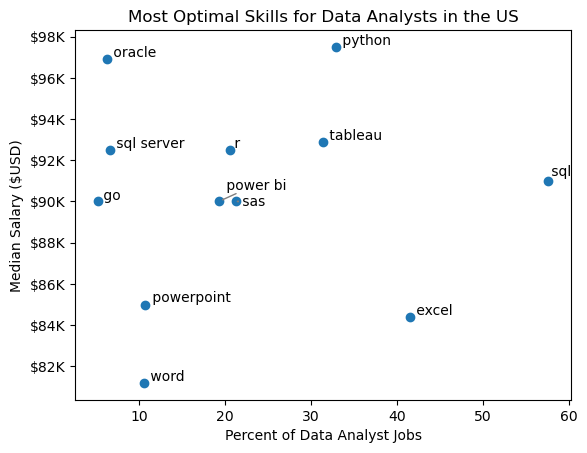

In [11]:
from adjustText import adjust_text

# Create scatter plot
plt.scatter(df_DA_skills_high_demand['skill_percent'], df_DA_skills_high_demand['median_salary'])
plt.xlabel('Percent of Data Analyst Jobs')
plt.ylabel('Median Salary ($USD)')
plt.title('Most Optimal Skills for Data Analysts in the US')

# Get current axes, set limits, and format axes
ax = plt.gca()
ax.yaxis.set_major_formatter(plt.FuncFormatter(lambda y, pos: f'${int(y/1000)}K'))  # Format y-axis

# Add labels to points and collect them in a list
texts = []
for i, txt in enumerate(df_DA_skills_high_demand.index):
    texts.append(plt.text(df_DA_skills_high_demand['skill_percent'].iloc[i], df_DA_skills_high_demand['median_salary'].iloc[i], " " + txt))
  

# Adjust text to avoid overlap and add arrows
adjust_text(texts, arrowprops=dict(arrowstyle='->', color='gray'))

plt.show()
 

In [12]:
df_technology = df['job_type_skills'].copy()

# remove duplicates
df_technology = df_technology.drop_duplicates()

# remove NaN values
df_technology = df_technology.dropna()

# combine all dictionaries into one
technology_dict = {}
for row in df_technology:
    row_dict = ast.literal_eval(row)  # convert string to dictionary
    for key, value in row_dict.items():
        if key in technology_dict:
            technology_dict[key] += value  # if key already exists in technology_dict, add value to existing key
        else:
            technology_dict[key] = value  # if key does not exist in technology_dict, add key and value
            
# remove duplicates by converting values to set then back to list
for key, value in technology_dict.items():
    technology_dict[key] = list(set(value))
    



In [13]:
df_technology = pd.DataFrame(list(technology_dict.items()), columns=['technology', 'skills'])

df_technology = df_technology.explode('skills')

df_technology

,technology,skills
0,analyst_tools,sharepoint
0,analyst_tools,qlik
0,analyst_tools,outlook
0,analyst_tools,powerpoint
0,analyst_tools,dax
...,...,...
9,sync,wire
9,sync,unify
9,sync,microsoft teams
9,sync,zoom


In [14]:
df_DA_skills_tech = df_DA_skills_high_demand.merge(df_technology, left_on='job_skills', right_on='skills')

In [15]:
df_DA_skills_tech_high_demand = df_DA_skills_tech[df_DA_skills_tech['skill_percent'] > skill_limit]

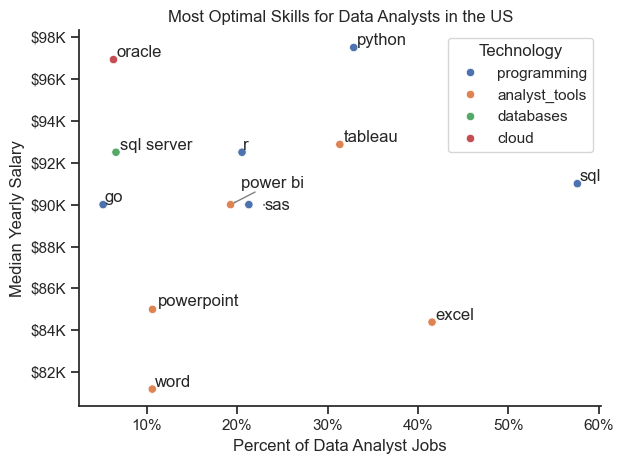

In [18]:
sns.scatterplot(
    data=df_DA_skills_tech_high_demand,
    x='skill_percent',
    y='median_salary',
    hue='technology'
)

sns.despine()
sns.set_theme(style='ticks')

# Prepare texts for adjustText
texts = []
for i, txt in enumerate(df_DA_skills_high_demand.index):
    texts.append(plt.text(df_DA_skills_high_demand['skill_percent'].iloc[i], df_DA_skills_high_demand['median_salary'].iloc[i], txt))

# Manually adjust positions for SAS and Power BI to avoid overlap
for text in texts:
    if text.get_text() == 'sas':
        text.set_position((text.get_position()[0] + 1.5, text.get_position()[1]))
    elif text.get_text() == 'Power BI':
        text.set_position((text.get_position()[0] - 2, text.get_position()[1]))

# Adjust text to avoid overlap
adjust_text(texts, arrowprops=dict(arrowstyle='->', color='gray'))

# Set axis labels, title, and legend
plt.xlabel('Percent of Data Analyst Jobs')
plt.ylabel('Median Yearly Salary')
plt.title('Most Optimal Skills for Data Analysts in the US')
plt.legend(title='Technology')

from matplotlib.ticker import PercentFormatter
ax = plt.gca()
ax.yaxis.set_major_formatter(plt.FuncFormatter(lambda y, pos: f'${int(y/1000)}K'))
ax.xaxis.set_major_formatter(PercentFormatter(decimals=0))

# Adjust layout and display plot 
plt.tight_layout()
plt.show()